In [ ]:
#Gridsearch

from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout


from keras.wrappers.scikit_learn import KerasClassifier

def create_model():
    def rmse(y_true, y_pred):
        from keras import backend
        return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
    def r_square(y_true, y_pred):
        from keras import backend as K
        SS_res =  K.sum(K.square(y_true - y_pred)) 
        SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
        return (1 - SS_res/(SS_tot + K.epsilon()))
    model = Sequential()
    model.add(LSTM(128,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation = 'sigmoid'))
    opt = tf.keras.optimizers.Adam(lr=1e-3,decay=1e-5)

    model.compile(loss='mse',optimizer=opt,metrics=['accuracy'])
    
    return model

model = KerasClassifier(build_fn=create_model,verbose=10)

batch_size = [5,10,20,50,100]
epochs = [1,5]

param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3,verbose=10)
grid_result = grid.fit(X_train, y_train,verbose=False)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# root mean squared error (rmse) for regression
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

#Train Model
model = Sequential()
model.add(LSTM(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation = 'sigmoid'))
opt = tf.keras.optimizers.Adam(lr=1e-3,decay=1e-5)

model.compile(loss='mse',optimizer=opt,metrics=["mean_squared_error", rmse, r_square])
history = model.fit(X_train,y_train,epochs=5,batch_size=20,validation_data=(X_test,y_test))

In [ ]:
#Write out model
name = 'test'

hist_df = pd.DataFrame(history.history)
model_json = model.to_json()
with open("ML_Models/{}_model.json".format(name), "w") as json_file:
    json_file.write(model_json)
model.save_weights("ML_Models/{}_model.h5".format(name))
with open('ML_Models/{}_hist.json'.format(name), 'w') as f:
    hist_df.to_json(f)
print("Saved model to disk")

# CLASS BASED

In [ ]:
import CO2_functions
import CO2_Processing
import pandas as pd
from CO2_functions import *
from CO2_Processing import *
import pickle
import numpy as np
from sklearn import preprocessing
import os
import matplotlib.pyplot as plt

class Dataset:
    def __init__(self,data_path,position_number):
        self.position_number = position_number
        self.data_path = data_path
    
    def _get_date_range(self):
        if self.position_number == 4:
            self.start_date = '2019-09-24'
            self.end_date = '2019-10-03'
        elif self.position_number == 6:
            self.start_date = '2019-11-06'
            self.end_date = '2019-11-27'
    
    def _data_retrieve(self):
        first_go = True #flag for first time through
        self._get_date_range()
        for single_date in daterange(self.start_date,self.end_date): #"daterange()" from CO2_processing
            if os.path.exists("{}/{}.pickle".format(self.data_path,single_date)):
                print("Retrieving data for {}".format(single_date))
                if first_go: #open and create the data structure
                    with open('{}/{}.pickle'.format(self.data_path,single_date), 'rb') as handle:
                        data = pickle.load(handle)
                    first_go=False
                else: #append the next day to the dta structure
                    with open('{}/{}.pickle'.format(self.data_path,single_date), 'rb') as handle:
                        new_data = pickle.load(handle)
                    for key in data:
                        if key in new_data.keys():
                            data[key] = pd.concat([data[key],new_data[key]])
            else: 
                print("No data found for {}".format(single_date))
                print(os.listdir(self.data_path))
                continue
        return data
        
    def _preprocess(self):
        print('Removing Impulses')
        data = remove_spikes(pd.read_pickle('Spike_ETs.pkl'),self._data_retrieve()) #CO2_Processing
        print('Downsampling and Concatenating')
        data = downsample_and_concatenate(data) #CO2_Processing
        
        if self.position_number == 4:
            data = sept24_26_correction(data) #CO2_Processing
            data = combine_vent_data(data,1) #Combine LI_Vent and Vent_Anem_Temp into a single df by sampling rate #CO2_processing
            data['Vent_Mass'] = moving_mass_flow(data['Vent_Mass']) #Add the moving mass flow rate based on function developed.  #CO2_processing
            data['Vent_Mass'] = pd.concat([\
                                   data['Vent_Mass'].loc[(data['Vent_Mass'].index>'2019-09-24 08:57:00')&\
                                                         (data['Vent_Mass'].index<'2019-09-26 08:00:00')],\
                                   data['Vent_Mass'].loc[(data['Vent_Mass'].index>'2019-09-26 12:00:00')&\
                                                         (data['Vent_Mass'].index<'2019-10-03 13:00:00')].interpolate()])
        elif self.position_number == 6:
            #Processing for position 6
            data = combine_vent_data(data,1) #Combine LI_Vent and Vent_Anem_Temp into a single df by sampling rate 
            data['Vent_Mass'] = moving_mass_flow(data['Vent_Mass']) #Add the moving mass flow rate based on function developed. 
            for key in data:
                data[key] = pd.concat([\
                               data[key].loc[(data[key].index>'2019-11-06 00:00:00')&(data[key].index<'2019-11-25 12:00:00')],\
                               data[key].loc[(data[key].index>'2019-11-25 17:00:00')&(data[key].index<'2019-11-27 10:28:00')]])

            data['Multi'] = data['Multi'].loc[data['Multi']['CO2_3']<600]
            data['Multi'] = data['Multi'].loc[data['Multi']['Wind_Velocity']>1.0]

        self.data = data
        

class ML_Data:
    def __init__(self,feature_columns,downsample_sec,periods_to_lag,tower,train_percent):
        self.feature_columns = feature_columns
        self.downsample_sec = downsample_sec
        self.periods_to_lag = periods_to_lag
        self.tower = tower
        self.train_percent = train_percent
    
    def _prepare_and_downsample(self,data):
        #get the correct data from the tower (multi or picarro)
        self.position_number = data.position_number
        if self.tower == 'Multi':
            tower = data.data['Multi']
        elif self.tower == 'Picarro':
            tower=data.data['Picarro']
        else:
            raise NameError('tower_id must be a valid tower, either "Multi" or "Picarro"')
        vent=data.data['Vent_Mass']
        tower_proc = dwn_sample(tower,self.downsample_sec) #CO2_Processing
        vent_proc = dwn_sample(vent,self.downsample_sec) #CO2_Processing
        df = pd.concat([tower_proc,vent_proc],axis=1)
        #Concatenate and add wind speed & direction if picarro data
        if self.tower == 'Picarro':
            df = wind_add(df,'ANEM_X','ANEM_Y') #CO2_functions
        #Drop columns
        if 'm_dot' not in self.feature_columns:
            self.feature_columns.append('m_dot')
        df = df[self.feature_columns]

        #Make mass flux the last column
        loc = df.columns.get_loc('m_dot')
        cols = df.columns.tolist()
        cols = cols[0:loc]+cols[(loc+1):]+[cols[loc]]
        df = df[cols]   
        
        self.df_preprocessed = df
    
    def _ML_Process(self,data):
        if not hasattr(self,'df_preprocessed'):
            self._prepare_and_downsample(data)
        n_periods = self.periods_to_lag#how many periods to lag
        n_features = len(self.df_preprocessed.columns)-1#how many features exist in the feature matrix (number of cols - target col)
        time_lagged = series_to_supervised(self.df_preprocessed.dropna(),n_in=0,n_out=n_periods,dropnan=False) #CO2_Processing
        time_lagged_reframed = delete_unwanted_cols(time_lagged) #delete unneccesary columns #CO2_Processing

        
        #Make mass flux at t the last column
        loc = time_lagged_reframed.columns.get_loc('m_dot(t)')
        cols = time_lagged_reframed.columns.tolist()
        cols = cols[0:loc]+cols[(loc+1):]+[cols[loc]]
        time_lagged_reframed = time_lagged_reframed[cols]
        
        values = time_lagged_reframed.dropna().values #Convert to numpy for processing
        min_max_scalar = preprocessing.MinMaxScaler() #setup scaling
        values_scaled = min_max_scalar.fit_transform(values) #scale all values from 0 to 1
        self.min_max_scalar = min_max_scalar
        
        train_size = int(len(values)*self.train_percent) 
        train = values_scaled[:train_size,:]  #Get train/test arrays
        test = values_scaled[train_size:,:]
                
        X_train,y_train = train[:,:-1], train[:,-1] #Get feature/target arrays
        X_test, y_test = test[:,:-1], test[:,-1]
        
        self.orig_X_train_shape = X_train.shape
        self.orig_X_test_shape = X_test.shape
        self.orig_y_train_shape = y_train.shape
        self.orig_y_test_shape = y_test.shape
        
        X_train = X_train.reshape((X_train.shape[0], n_periods, n_features)) 
        X_test = X_test.reshape((X_test.shape[0], n_periods, n_features))
        
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test   

In [ ]:
import tensorflow as tf
from tensorflow import keras
import CO2_functions
import CO2_Processing
import pandas as pd
from CO2_functions import *
from CO2_Processing import *
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import os
from keras.models import model_from_json
import json
from keras import backend

class ML_Model_Builder:
    def __init__(self,activation,neurons,dropout_rate,learn_rate,decay,batch_size,epochs):
        self.activation = activation
        self.neurons = neurons
        self.dropout_rate = dropout_rate
        self.learn_rate = learn_rate
        self.decay = decay
        self.batch_size = batch_size
        self.epochs = epochs

    def _create_model(self):
        def rmse(y_true, y_pred):
            return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
        
        model = Sequential()
        model.add(LSTM(self.neurons,activation=self.activation))
        model.add(Dropout(self.dropout_rate))
        model.add(Dense(1,activation = 'sigmoid'))
        
        opt = tf.keras.optimizers.Adam(lr=self.learn_rate,decay=self.decay)
        self.opt_string = 'tf.keras.optimizers.Adam(lr=self.learn_rate,decay=self.decay)'
        
        self.loss = 'mse'
        
        model.compile(loss=self.loss,optimizer=opt,metrics=[rmse])
        self.model = model
        
    def _train_model(self,data):
        self.position_number = data.position_number
        self.periods_to_lag = data.periods_to_lag
        self.downsample_sec = data.downsample_sec
        self.feature_columns = data.feature_columns
        self.tower = data.tower
        self.train_percent = data.train_percent
        if not hasattr(self,'model'):
            self._create_model()
        
        print(f"Downsampling = {self.downsample_sec}\nLag Periods = {self.periods_to_lag}\
        \nactivation={self.activation}\nneurons={self.neurons}\ndropout_rate={self.dropout_rate}\
        \nlearn_rate={self.learn_rate}\ndecay={self.decay}\nbatch size={batch_size}\nepochs={epochs}")
        
        self.history = self.model.fit(data.X_train,data.y_train,epochs=self.epochs,batch_size=self.batch_size,\
                                      validation_data=(data.X_test,data.y_test),verbose=0)
        
        print(f"Final RMSE for this model: {self.history.history['rmse'][-1]}")
    
    def _fit_data(self,data):
        print(f"Fitting data from X_test")
        data.y_fit = self.model.predict(data.X_test)

# MANUAL GRIDSEARCH

In [ ]:
from CO2_Dataset_Preparation import *
from ML_Model_Master import *

print("-------------------------BEGIN: GRIDSEARCH TESTING-------------------------")
print("-------------------------PREPROCESSSING-------------------------")
position_number = 4
data = Dataset('../CO2_Data_Final',position_number)
data._preprocess()

In [ ]:
print("-------------------------BUILD AND TRAIN MODELS-------------------------")
feature_columns = ['Pic_CO2','ANEM_X','ANEM_Y','ANEM_Z','wd','ws']
downsample_sec = 600
periods_to_lag = [5,10]
tower = 'Picarro'
train_percent = 0.7

activation = 'relu'
neurons = [64,128]
dropout_rate = [0.2,0.3]
learn_rate = [0.001,1e-3]
decay = [1e-5,1e-6]
batch_size = [10,20]
epochs = [1,5]

tot_train = len(periods_to_lag)*len(neurons)*len(dropout_rate)*len(learn_rate)*len(decay)*len(batch_size)*len(epochs)-1

models = []
i = 0

for lag in periods_to_lag:
    ml_data = ML_Data(feature_columns,downsample_sec,lag,tower,train_percent)
    ml_data._ML_Process(data)
    for neur in neurons:
        for dr in dropout_rate:
            for lr in learn_rate:
                for dec in decay:
                    for bs in batch_size:
                        for ep in epochs:
                            print(f"---Training Model: {i} of {tot_train}---")
                            ml_model = ML_Model_Builder(activation,neur,dr,lr,dec,bs,ep)
                            ml_model._train_model(ml_data)
                            models.append(ml_model)
                            i+=1
       
    
error_name  = 'rmse'   

error_vals = []
for m in models:
    error_vals.append(m.history.history[error_name][-1])
best_idx = error_vals.index(min(error_vals))

print("-------------------------RESULTS-------------------------")
print(f"Best score for '{error_name}' was {min(error_vals)} in model {best_idx}")
print(f"Downsampling Seconds: {models[best_idx].downsample_sec}\n\
Lag Periods: {models[best_idx].periods_to_lag}\n\
Activation: {models[best_idx].activation}\n\
Neurons: {models[best_idx].neurons}\n\
Learning Rate: {models[best_idx].learn_rate}\n\
Decay: {models[best_idx].decay}\n\
Epochs: {models[best_idx].epochs}")


print("-------------------------SAVE FILE-------------------------")
import pickle
file_name = 'ML_Models/models_test.pkl'
with open(file_name, 'wb') as models_file:
     pickle.dump(models, models_file)
print(f"Saved list of models to {file_name}")
print(f"Models built with optimizer: {models[best_idx].opt_string}")

# GRIDSEARCH LOAD AND VIEW


In [3]:
import pickle
from CO2_Dataset_Preparation import *
from ML_Model_Master import *

with open('ML_Models/models_test.pkl', 'rb') as models_file:
    models = pickle.load(models_file)

In [4]:
models

In [5]:
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

for mod in models:
    opt = tf.keras.optimizers.Adam(lr=mod.learn_rate,decay=mod.decay)
    mod.model.compile(loss=mod.loss,optimizer=opt,metrics=[rmse])


In [7]:
error_name  = 'rmse'   

error_vals = []
for m in models:
    error_vals.append(m.history.history[error_name][-1])
best_idx = error_vals.index(min(error_vals))

print(f"Best score for '{error_name}' was {min(error_vals)} in model {best_idx}")
print(f"Downsampling Seconds: {models[best_idx].downsample_sec}\n\
Lag Periods: {models[best_idx].periods_to_lag}\n\
Activation: {models[best_idx].activation}\n\
Neurons: {models[best_idx].neurons}\n\
Learning Rate: {models[best_idx].learn_rate}\n\
Decay: {models[best_idx].decay}\n\
Epochs: {models[best_idx].epochs}")

data = Dataset('../CO2_Data_Final',models[best_idx].position_number)
data._preprocess()

ml_data = ML_Data(models[best_idx].feature_columns,models[best_idx].downsample_sec\
                      ,models[best_idx].periods_to_lag,models[best_idx].tower,models[best_idx].train_percent)
ml_data._ML_Process(data)

Best score for 'rmse' was 0.2754964530467987 in model 0
Downsampling Seconds: 600
Lag Periods: 5
Activation: relu
Neurons: 64
Learning Rate: 0.001
Decay: 1e-05
Epochs: 1
Removing Impulses
Retrieving data for 2019-09-24
Retrieving data for 2019-09-25
Retrieving data for 2019-09-26
Retrieving data for 2019-09-27
Retrieving data for 2019-09-28
Retrieving data for 2019-09-29
Retrieving data for 2019-09-30
Retrieving data for 2019-10-01
Retrieving data for 2019-10-02
Retrieving data for 2019-10-03
Downsampling and Concatenating
Concatenating Picarro Data
Concatenating Multi Data
setting night vent data to zero
Downsampling by mean at 600 seconds
Downsampling by mean at 600 seconds
Adding Wind Direction as 'wd'
Adding Wind Speed as 'ws'


Fitting data from X_test


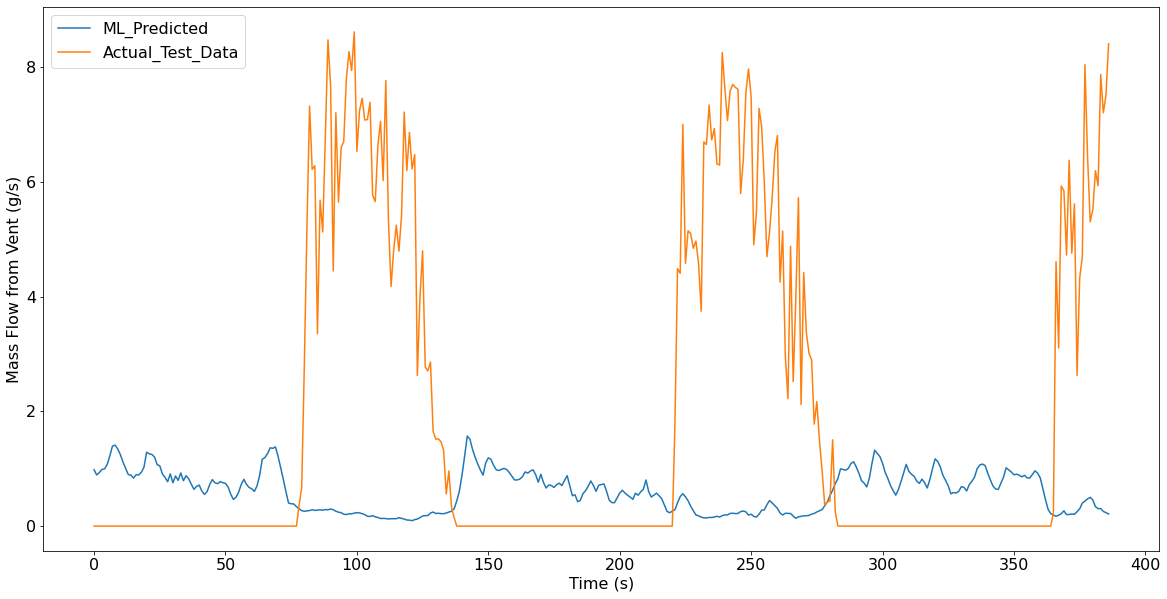

In [8]:
import matplotlib.pyplot as plt

i=best_idx

models[i]._fit_data(ml_data)

#Return to original data shape and scale
X_test_original_shape = ml_data.X_test.reshape(ml_data.orig_X_test_shape) #reshape from 3d time
y_test_original_shape = ml_data.y_test.reshape(ml_data.orig_y_test_shape)#reshape from 3d time 

merged_tests = np.concatenate((X_test_original_shape,y_test_original_shape[:,None]),axis=1) #concat X and y
unscaled_test = pd.DataFrame(ml_data.min_max_scalar.inverse_transform(merged_tests)).iloc[:,-1] #unscale using declared scalar

y_fit_original_shape = ml_data.y_fit.reshape(ml_data.orig_y_test_shape)
merged_tests = np.concatenate((X_test_original_shape,y_fit_original_shape[:,None]),axis=1)
unscaled_fit = pd.DataFrame(ml_data.min_max_scalar.inverse_transform(merged_tests)).iloc[:,-1]

#Put into pandas df
comparison = pd.concat([unscaled_test,unscaled_fit],axis=1)
comparison.columns = ['test','fit']

#PLOT PREDICTED VS OBSERVED
fig, ax = plt.subplots(figsize = (20,10))
# ax.plot(ml_data.y_fit,label='ML_Fit_to_Test')
# ax.plot(ml_data.y_test,label='Actual_Test_Data')

roll = 1

ax.plot(comparison['fit'].rolling(roll).mean(),label='ML_Predicted')
ax.plot(comparison['test'].rolling(roll).mean(),label='Actual_Test_Data')

ax.set_xlabel('Time (s)',fontsize=16)
ax.set_ylabel('Mass Flow from Vent (g/s)',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)


ax.legend(fontsize=16)
plt.show()